<a href="https://colab.research.google.com/github/JohnPPinto/Deep-Learning-Projects/blob/main/Classification_of_Disaster_Tweets_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Disaster Tweets Using PyTorch

**Project Description**

Twitter has become an important communication channel in times of emergency.

The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

<img src="https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png" width="300">

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

**Project Dataset**

We will be using the dataset provided by Kaggle, you can find the dataset over [here](https://www.kaggle.com/competitions/nlp-getting-started).

The dataset contains Train and Test set containing the following information:
* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

This dataset was hand classified by humans and contains a total of 10,000 tweets.

**Project Objective**

The goal is to predict whether the provided tweet is about a real disaster or not. If it is a disaster tweet then label it as "1" or "0" for not a disaster tweet.

## Getting the Data

To download the data from Kaggle, you will need the API key file.

To get the Kaggle API key file you will need to login into [Kaggle](http://www.kaggle.com), then go into your settings and select the option "Create New Token" and download the JSON file.

After downloading the key, upload the key in the colab to use it.

In [1]:
import os
import re
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# storing kaggle key path in environment
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
data_dirpath = 'data'

In [3]:
# Downloading the data using the API file
!kaggle competitions download -c nlp-getting-started -p $data_dirpath

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
shutil.unpack_archive('data/nlp-getting-started.zip', data_dirpath)

In [5]:
# Reading the downladed files
train_filepath = os.path.join(data_dirpath, 'train.csv')
test_filepath = os.path.join(data_dirpath, 'test.csv')
sample_sub_filepath = os.path.join(data_dirpath, 'sample_submission.csv')

raw_train_df = pd.read_csv(train_filepath)
test_df = pd.read_csv(test_filepath)
sample_submission_df = pd.read_csv(sample_sub_filepath)

raw_train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [7]:
sample_submission_df

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [8]:
# Checking total counts of the target label
raw_train_df.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

If you see the raw train dataset, we have the tweets in text column and labels in the target column.

For the test dataset we have the text and we need to make prediction for this text. The predicted labels need to be fitted in the format given in the sample submission dataset.

## Data Preparation for Training

In [9]:
# Initiating the tokenizer and lemmatizer
tokenizer = TweetTokenizer(preserve_case=False,
                           reduce_len=True,
                           strip_handles=True)
lemmatizer = WordNetLemmatizer()

# Writing a function that tokenizes any text and also applies lemmatization.
def tokenize_text(text: str):
    # Removes prefix www or http or punctuation and keeps # and @
    text = re.sub(r'www\S*|http\S*|[^\w\s#@]', ' ', text)
    return [lemmatizer.lemmatize(token).lower()
            for token in tokenizer.tokenize(text)]

tokenize_example = tokenize_text(raw_train_df["text"][100])

In [10]:
print(f'Original Text: {raw_train_df["text"][100]}\n')
print(f'Tokenized Text: {tokenize_example}')

Original Text: .@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad

Tokenized Text: ['#bahrain', 'police', 'had', 'previously', 'died', 'in', 'a', 'road', 'accident', 'they', 'were', 'not', 'killed', 'by', 'explosion']


In [11]:
# Initializing stop words
stop_words = stopwords.words('english')

# Applying stopwords on the example
[token for token in tokenize_example if token not in stop_words]

['#bahrain',
 'police',
 'previously',
 'died',
 'road',
 'accident',
 'killed',
 'explosion']

In [12]:
# Generating vectors using TF-IDF method
input_features = 1000
vectorizer = TfidfVectorizer(lowercase=True,
                             tokenizer=tokenize_text,
                             stop_words=stop_words,
                             max_features=input_features)

# Fitting the text data into the vectorizer
inputs = vectorizer.fit_transform(raw_train_df.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


In [13]:
vectorizer.get_feature_names_out()[:100]

array(['#', '#best', '#earthquake', '#gbbo', '#hiroshima', '#hot',
       '#islam', '#news', '#nowplaying', '#prebreak', '0', '00', '01',
       '05', '06', '08', '1', '10', '100', '11', '12', '12000', '13',
       '15', '16', '16yr', '17', '18', '2', '20', '2015', '24', '25', '3',
       '30', '4', '40', '5', '50', '6', '60', '7', '70', '70th', '8', '9',
       '@', 'abc', 'ablaze', 'accident', 'across', 'act', 'action',
       'actually', 'added', 'affected', 'aftershock', 'ago', 'air',
       'aircraft', 'airplane', 'airport', 'alarm', 'almost', 'alone',
       'already', 'also', 'always', 'ambulance', 'america', 'american',
       'amid', 'amp', 'ancient', 'angry', 'animal', 'annihilated',
       'annihilation', 'anniversary', 'another', 'answer', 'anthrax',
       'anyone', 'anything', 'apocalypse', 'apollo', 'appears', 'area',
       'armageddon', 'army', 'around', 'arrested', 'arson', 'arsonist',
       'article', 'atomic', 'attack', 'attacked', 'aug', 'august'],
      dtype=obj

In [14]:
inputs.shape

(7613, 1000)

In [15]:
print(inputs[100])

  (0, 338)	0.4278672663861625
  (0, 496)	0.37766961247431197
  (0, 745)	0.4357727917605826
  (0, 49)	0.3791493532694516
  (0, 690)	0.356902883190019
  (0, 286)	0.46180454741798693


In [16]:
inputs[100].toarray()[:,49:497]

array([[0.37914935, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [17]:
# Transforming the test set data using the same vectorizer
test_inputs = vectorizer.transform(test_df.text)
test_inputs.shape

(3263, 1000)

In [18]:
# Getting the targets from the raw training data
targets = raw_train_df.target.values
targets, targets.shape

(array([1, 1, 1, ..., 1, 1, 1]), (7613,))

## Splitting the Dataset and Transforming into Tensor

In [19]:
# Splitting the dataset into train and val set
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs,
                                                                        targets,
                                                                        test_size=0.3,
                                                                        random_state=42)
train_inputs.shape, val_inputs.shape, train_targets.shape, val_targets.shape

((5329, 1000), (2284, 1000), (5329,), (2284,))

In [20]:
# Converting the dataset into PyTorch tensor
train_tensor = F.normalize(torch.tensor(train_inputs.toarray()).float(), dim=0)
val_tensor = F.normalize(torch.tensor(val_inputs.toarray()).float(), dim=0)
train_tensor.shape, val_tensor.shape

(torch.Size([5329, 1000]), torch.Size([2284, 1000]))

In [21]:
print(train_inputs[0], '\n', train_tensor[0][30:159])

  (0, 40)	0.3200223723983698
  (0, 158)	0.28784255557844507
  (0, 100)	0.6493376264628425
  (0, 974)	0.31786264986962554
  (0, 213)	0.258511832729047
  (0, 995)	0.256781483546599
  (0, 453)	0.31192790095332995
  (0, 30)	0.24898235618930367 
 tensor([0.0869, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1803, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3286, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000

In [22]:
# Creating PyTorch dataset using the train and val set
train_dataset = TensorDataset(train_tensor, torch.tensor(train_targets))
val_dataset = TensorDataset(val_tensor, torch.tensor(val_targets))

In [23]:
print(train_dataset, len(train_dataset), '\n')
print(val_dataset, len(val_dataset))

<torch.utils.data.dataset.TensorDataset object at 0x7967b968e4d0> 5329 

<torch.utils.data.dataset.TensorDataset object at 0x7967b968e170> 2284


In [24]:
# Creating PyTorch dataloaders using the dataset
BATCH_SIZE = 256
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=os.cpu_count(),
                          pin_memory=True,
                          drop_last=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=os.cpu_count(),
                        pin_memory=True,
                        drop_last=True)
next(iter(train_loader)), len(train_loader), len(val_loader)

([tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
          0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
          1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
          1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
          1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
          0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
          0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
          0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,

## Building a Baseline Model

In [25]:
# Creating a logistic regression model using pytorch
class BaseLogRegrModel(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.input_layer = nn.Linear(input_features, 512)
        self.layer1 = nn.Linear(512, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.final_layer = nn.Linear(64, 1)

    def forward(self, x):
        return self.final_layer(self.layer3(self.layer2(self.layer1(self.input_layer(x)))))

model = BaseLogRegrModel(input_features=input_features)
model

BaseLogRegrModel(
  (input_layer): Linear(in_features=1000, out_features=512, bias=True)
  (layer1): Linear(in_features=512, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (final_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [26]:
# Writing a function for fitting the dataset into model
def model_fit(model, train_loader, val_loader,  epochs, lr):
    # Initiating the loss and optimizer
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr)

    history = []
    for epoch in range(1, epochs+1):
        model.train()

        # Training the model
        for inputs, targets in train_loader:
            pred = model(inputs)
            loss = loss_fn(pred, targets.float().unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation the model
        losses, accs, f1s = [], [], []

        model.eval()
        with torch.inference_mode():
            for inputs, targets in train_loader:
                pred = model(inputs)
                loss = loss_fn(pred, targets.float().unsqueeze(1))
                losses.append(loss.item())

                probs = torch.sigmoid(pred[:,0])
                preds = (probs > 0.5).int()
                acc = accuracy_score(targets, preds)
                f1 = f1_score(targets, preds)

                accs.append(acc)
                f1s.append(f1)

            result = np.mean(losses), np.mean(accs), np.mean(f1s)
        loss, acc, f1 = result
        print('Epoch: {}; Loss: {:.4f}; Accuracy: {:.4f}; F1 Score: {:.4f}'.format(
            epoch, loss, acc, f1))
        history.append(result)

    return history

In [27]:
# Performing the model training
model = BaseLogRegrModel(input_features=input_features)
history = model_fit(model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    epochs=100,
                    lr=1e-3)

Epoch: 1; Loss: 0.5430; Accuracy: 0.7947; F1 Score: 0.7154
Epoch: 2; Loss: 0.3941; Accuracy: 0.8350; F1 Score: 0.8040
Epoch: 3; Loss: 0.3517; Accuracy: 0.8393; F1 Score: 0.8017
Epoch: 4; Loss: 0.3420; Accuracy: 0.8475; F1 Score: 0.8106
Epoch: 5; Loss: 0.3374; Accuracy: 0.8510; F1 Score: 0.8168
Epoch: 6; Loss: 0.3237; Accuracy: 0.8559; F1 Score: 0.8296
Epoch: 7; Loss: 0.3264; Accuracy: 0.8592; F1 Score: 0.8313
Epoch: 8; Loss: 0.3214; Accuracy: 0.8557; F1 Score: 0.8255
Epoch: 9; Loss: 0.3212; Accuracy: 0.8619; F1 Score: 0.8357
Epoch: 10; Loss: 0.3179; Accuracy: 0.8561; F1 Score: 0.8262
Epoch: 11; Loss: 0.3253; Accuracy: 0.8547; F1 Score: 0.8136
Epoch: 12; Loss: 0.3192; Accuracy: 0.8598; F1 Score: 0.8310
Epoch: 13; Loss: 0.3183; Accuracy: 0.8561; F1 Score: 0.8240
Epoch: 14; Loss: 0.3279; Accuracy: 0.8541; F1 Score: 0.8361
Epoch: 15; Loss: 0.3154; Accuracy: 0.8592; F1 Score: 0.8283
Epoch: 16; Loss: 0.3213; Accuracy: 0.8629; F1 Score: 0.8358
Epoch: 17; Loss: 0.3152; Accuracy: 0.8596; F1 Sco

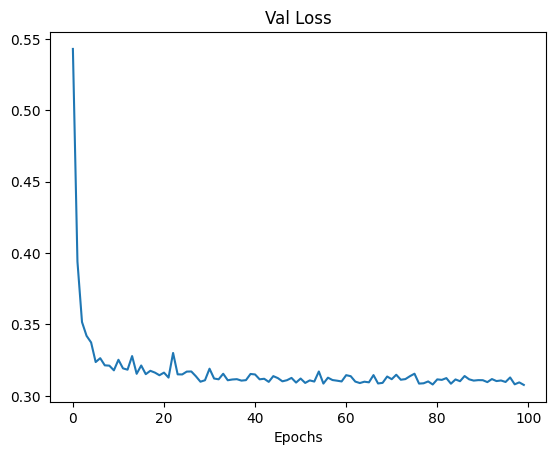

In [28]:
# Ploting the result that the model has produced
plt.plot([i[0] for i in history])
plt.xlabel('Epochs')
plt.title('Val Loss');

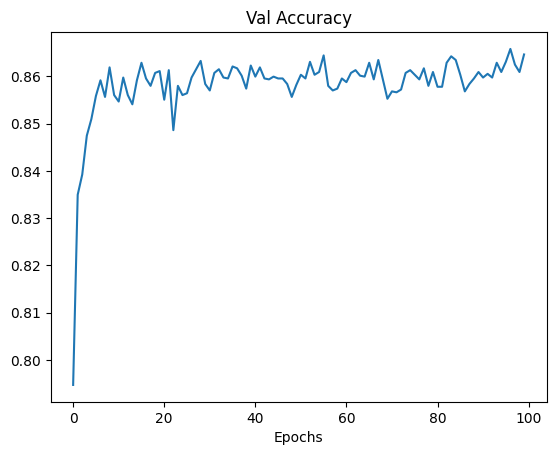

In [29]:
plt.plot([i[1] for i in history])
plt.xlabel('Epochs')
plt.title('Val Accuracy');

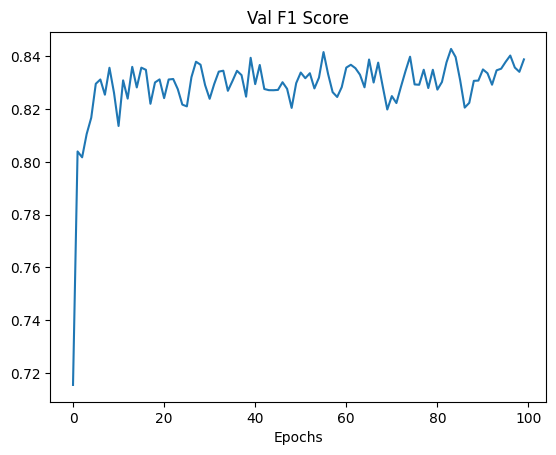

In [30]:
plt.plot([i[2] for i in history])
plt.xlabel('Epochs')
plt.title('Val F1 Score');

## Making Prediction for Submission

In [33]:
test_inputs.shape

(3263, 1000)

In [37]:
# Converting the test data into pytorch dataset and dataloader
test_dataset = TensorDataset(torch.Tensor(test_inputs.toarray()).float())
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         drop_last=False)
next(iter(test_loader)), len(test_loader)

([tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4938,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])],
 13)

In [48]:
# Function to predict test data
def predict(model, test_loader):
    prediction = []
    model.eval()
    with torch.inference_mode():
        for inputs in test_loader:
            pred = model(inputs[0])
            probs = torch.sigmoid(pred)[:,0]
            preds = (probs > 0.5).int()
            prediction += list(preds.numpy())
    return prediction

In [49]:
test_prediction = predict(model=model,
                          test_loader=test_loader)

In [51]:
test_df.text[:10]

0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
5                   We're shaking...It's an earthquake
6    They'd probably still show more life than Arse...
7                                    Hey! How are you?
8                                     What a nice hat?
9                                            Fuck off!
Name: text, dtype: object

In [50]:
test_prediction[:10]

[1, 1, 1, 0, 1, 1, 0, 0, 0, 0]

In [56]:
# Creating a submission dataframe with the predicted result
submission_df = test_df[['id']].copy()
submission_df['target'] = test_prediction
submission_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [57]:
submission_df.to_csv('submission.csv', index=None)